# Ingestion 

## Load Documents with ids

In [79]:
import json
import pandas as pd

from tqdm.auto import tqdm
from openai import OpenAI
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer

In [80]:
with open('../data/document-with-ids.json', 'r') as file:
    documents = json.load(file)

In [81]:
documents[0]

{'category': 'Manage existing benefit',
 'question': 'How do I update my benefit information?',
 'answer': 'You can update your benefit information online through your account.',
 'section': 'general claim benefits',
 'id': '30eada08-5708-5c5c-9df8-0f7d5d4dc131'}

## Load ground_truth data

In [82]:
df_ground_truth = pd.read_csv('../data/ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

In [83]:
ground_truth[10]

{'question': 'Is it possible to appeal?',
 'section': 'general claim benefits',
 'document': '8d000ade-6c2b-571c-aa61-5d38eb463cf8'}

In [84]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/home/codespace/.local/share/virtualenvs/benefits-claims-assitant-w_hr6DTK/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Indexing Elasticsearch with Data

In [95]:
es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "answer": {"type": "text"},
            "category": {"type": "text"},
            "question": {"type": "text"},
            "section": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_answer_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "benefit-claims"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'benefit-claims'})

In [96]:
for doc in tqdm(documents):
    question = doc['question']
    answer = doc['answer']
    doc['question_answer_vector'] = model.encode(question + ' ' + answer)

    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [00:17<00:00, 24.96it/s]


## Retrieval

In [97]:
def elastic_search_knn(field, vector, section):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "section": section
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["answer", "section", "question", "category", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_answer_vector_knn(q):
    question = q['question']
    section = q['section']

    v_q = model.encode(question)

    return elastic_search_knn('question_answer_vector', v_q, section)

In [98]:
question_answer_vector_knn(dict(
    question="Can I get sick pay if I'm self-isolating?",
    section ='general claim benefits'
))

[{'question': "Can I get sick pay if I'm self-isolating?",
  'answer': "Yes Statutory Sick Pay is available if you're self-isolating.",
  'section': 'general claim benefits',
  'id': '1de35e0b-f233-554c-84ef-fc30494e0ea0',
  'category': 'Temporarily unable to work'},
 {'question': 'How do I apply for sick pay?',
  'answer': 'You need to provide a fit note from your doctor to apply for sick pay.',
  'section': 'general claim benefits',
  'id': 'ecc42084-d88e-5bf0-8070-a18552c283bb',
  'category': 'Temporarily unable to work'},
 {'question': 'What is statutory sick pay?',
  'answer': "Statutory Sick Pay is a legal requirement for employers to pay you if you're ill.",
  'section': 'general claim benefits',
  'id': 'ee6a77ec-d4ef-50f7-9762-04cc228b3a48',
  'category': 'Temporarily unable to work'},
 {'question': 'How do I claim SSP?',
  'answer': 'Statutory Sick Pay is claimed through your employer if you’re too ill to work.',
  'section': 'general claim benefits',
  'id': 'fa497683-9615-5

## RAG flow with Vector Search (encoded question and answer)

In [89]:
def build_prompt(query, search_results):
 
{context}    prompt_template = """
You are an expert in United Kingdom Benefit Claims and Medical Negligence Claims. Answer the QUESTION based on the CONTEXT from 
the FAQ databases of Benefits database and NHS claims management. 
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"category: {doc['category']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\nsection: {doc['section']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    
    return prompt

In [90]:
client = OpenAI()

def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [91]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = question_answer_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [92]:
rag(ground_truth[50])

"Yes, Statutory Sick Pay is available if you're self-isolating."

In [94]:
documents[50]

{'category': 'Temporarily unable to work',
 'question': 'How do I report a workplace injury?',
 'answer': 'Report workplace injuries to your employer and apply for compensation if eligible.',
 'section': 'general claim benefits',
 'id': '39d45737-266e-5bbb-8d99-70edd404aa15',
 'question_answer_vector': array([-2.02777479e-02,  9.49940458e-02,  3.13753299e-02, -3.31201963e-02,
         7.92978257e-02,  8.51311311e-02, -5.75557724e-02,  7.16471300e-02,
        -3.63708586e-02, -1.58154927e-02, -4.34555225e-02, -2.56604534e-02,
        -2.18547545e-02,  3.15416828e-02, -5.98013168e-03, -7.39012063e-02,
        -4.09065746e-02,  9.90735665e-02, -3.12540978e-02, -3.57698128e-02,
         2.73585040e-02,  4.78895679e-02,  2.36578826e-02, -1.17720868e-02,
        -5.47719821e-02,  2.06689220e-02, -1.57870483e-02,  3.65449265e-02,
        -5.58490418e-02,  5.62503142e-03, -6.08176105e-02, -5.58923818e-02,
        -2.87925992e-02,  3.82743701e-02, -1.07303374e-02, -2.36929171e-02,
        -6.47

In [93]:
ground_truth[50]

{'question': 'Is Statutory Sick Pay applicable to those who are self-isolating?',
 'section': 'general claim benefits',
 'document': '1de35e0b-f233-554c-84ef-fc30494e0ea0'}

## Generating Answers for LLM comparison
- gpt-40
- gpt-4o-mini

## gpt-4o-mini

In [22]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = question_answer_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [23]:
doc_idx = {d['id']: d for d in documents}

In [24]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

In [ ]:
answers[2]

In [ ]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, value in answers.items():
    results_gpt4o_mini[i] = value.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)

In [ ]:
df_gpt4o_mini.to_csv('generate_data/resultsgpt4o-mini.csv', index=False)

## gpt-4o

In [ ]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_answer_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [ ]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

In [ ]:
results_gpt4o = [None] * len(ground_truth)

for i, value in answers.items():
    results_gpt4o[i] = value.copy()
    results_gpt4o[i].update(ground_truth[i])

In [ ]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [ ]:
df_gpt4o.to_csv('generate_data/resultsgpt4o.csv', index=False)

# Cosine Similarity

- Loading generated answers from:
- gpt4o
- gpt4o-mini
- flant5

## gpt-4o

In [26]:
df_gpt4o = pd.read_csv('../generate_data/resultsgpt4o.csv')
resultsgpt4o = df_gpt4o.to_dict(orient='records')
# resultsgpt4o[0]

In [27]:
df_gpt4o_mini = pd.read_csv('../generate_data/resultsgpt4o-mini.csv')
resultsgpt4o_mini = df_gpt4o_mini.to_dict(orient='records') 

In [28]:
df_flant5 = pd.read_csv('../generate_data/resultsflant5.csv')
resultsflant5 = df_flant5.to_dict(orient='records')

In [29]:
record = resultsgpt4o[0]

In [30]:
def compute_similarity(record):
    answer_original = record['answer_orig']
    answer_llm = record['answer_llm']

    vector_llm = model.encode(answer_llm)
    vector_orig = model.encode(answer_original)

    return vector_llm.dot(vector_orig)

In [31]:
similarity = []

for record in tqdm(resultsgpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2055/2055 [01:25<00:00, 24.15it/s]


In [32]:
df_gpt4o['cosine_sim'] = similarity
df_gpt4o.describe()

,cosine_sim
count,2055.000000
mean,0.794962
std,0.155748
min,-0.007994
25%,0.717219
50%,0.828932
75%,0.903173
max,1.000000


**On Average the mean cosine similarity of gpt-4o performance is 79%**

/tmp/ipykernel_7485/3200298923.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine_sim'])
/tmp/ipykernel_7485/3200298923.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="cosine similarity",loc="upper left")


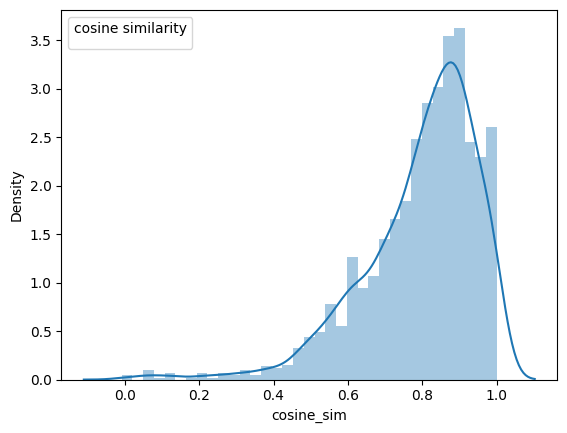

In [33]:
import seaborn as sns

import matplotlib.pyplot as plt
sns.distplot(df_gpt4o['cosine_sim'])
plt.legend(title="cosine similarity",loc="upper left")

plt.show()

## gpt-4o-mini

In [34]:
record = resultsgpt4o_mini[0]

In [35]:
def compute_similarity(record):
    answer_original = record['answer_orig']
    answer_llm = record['answer_llm']

    vector_llm = model.encode(answer_llm)
    vector_orig = model.encode(answer_original)

    return vector_llm.dot(vector_orig)

In [36]:
similarity_mini = []

for record in tqdm(resultsgpt4o_mini):
    sim = compute_similarity(record)
    similarity_mini.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2055/2055 [01:20<00:00, 25.63it/s]


In [37]:
df_gpt4o_mini['cosine_sim'] = similarity_mini
df_gpt4o_mini.describe()

,cosine_sim
count,2055.000000
mean,0.799894
std,0.152647
min,-0.132416
25%,0.730513
50%,0.836938
75%,0.904503
max,1.000000


**On Average the mean cosine similarity of gpt-4o-mini performance is 80%**

/tmp/ipykernel_7485/3518590851.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine_sim'])
/tmp/ipykernel_7485/3518590851.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="cosine similarity",loc="upper left")


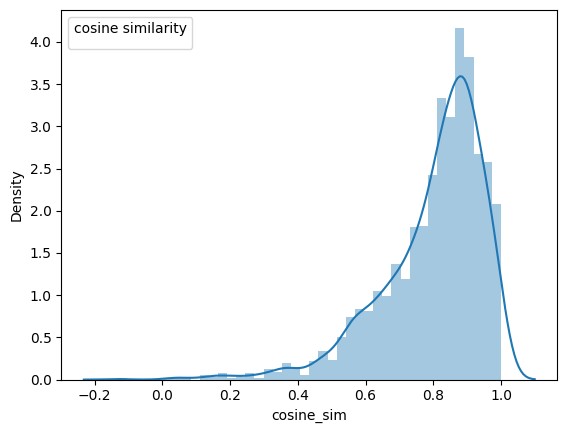

In [38]:
sns.distplot(df_gpt4o_mini['cosine_sim'])
plt.legend(title="cosine similarity",loc="upper left")

plt.show()

### comparing gpt-4o with gpt4o-mini

/tmp/ipykernel_7485/3764530184.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine_sim'], label='gpt-4o')
/tmp/ipykernel_7485/3764530184.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine_sim'], label='gpt-4o-mini')


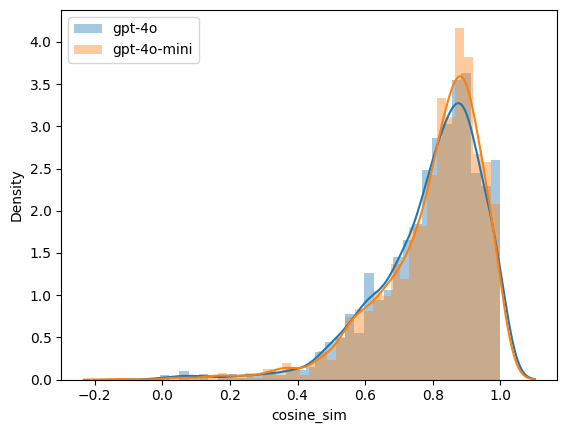

In [39]:
sns.distplot(df_gpt4o['cosine_sim'], label='gpt-4o')
sns.distplot(df_gpt4o_mini['cosine_sim'], label='gpt-4o-mini')

plt.legend()

## flant5

In [40]:
record = resultsflant5[0]

In [41]:
def compute_similarity(record):
    answer_original = record['answer_orig']
    answer_llm = record['answer_llm']

    vector_llm = model.encode(answer_llm)
    vector_orig = model.encode(answer_original)

    return vector_llm.dot(vector_orig)

In [ ]:
similarity_t5 = []

for record in tqdm(resultsflant5):
    sim = compute_similarity(record)
    similarity_t5.append(sim)

In [ ]:
df_flant5['cosine_sim'] = similarity_t5
df_flant5.describe()

**On average Google flant5 gave the worst average of 50%**

In [ ]:
sns.distplot(df_flant5['cosine_sim'])
plt.legend(title="cosine similarity",loc="upper left")

plt.show()

In [ ]:
sns.distplot(df_gpt4o['cosine_sim'], label='gpt-4o')
sns.distplot(df_gpt4o_mini['cosine_sim'], label='gpt-4o-mini')
sns.distplot(df_flant5['cosine_sim'], label='flant5')

plt.legend()

## LLM as a judge

In [49]:
prompt1_template="""
You are a judge evaluating the quality of a generated answer. Below is the original answer, 
a question generated based on this answer, and the final answer generated for that question. 
Your task is to evaluate the relevance and similarity of the generated answer compared to the original answer, and label it as one of the following:

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()
prompt2_template="""
You are a judge evaluating the quality of a generated answer based solely on the relevance to the given question. 
Below is the generated question and the final generated answer. 
Your task is to assess how well the generated answer responds to the question and label it as one of the following:

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [47]:
resultsgpt4o_mini =df_gpt4o_mini.to_dict(orient='records')

In [48]:
record = resultsgpt4o_mini[0]

In [55]:
evaluations = []

for record in tqdm(resultsgpt4o_mini):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2055/2055 [37:26<00:00,  1.09s/it]


In [56]:
json_evals = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evals.append(json_eval)

In [57]:
df_evals = pd.DataFrame(json_evals)

In [60]:
df_evals.Relevance.value_counts()

Relevance
RELEVANT           1916
PARTLY_RELEVANT     102
NON_RELEVANT         37
Name: count, dtype: int64

In [61]:
prompt = prompt2_template.format(**record)
print(prompt)

You are a judge evaluating the quality of a generated answer based solely on the relevance to the given question. 
Below is the generated question and the final generated answer. 
Your task is to assess how well the generated answer responds to the question and label it as one of the following:

Here is the data for evaluation:

Question: What’s the recommended course of action if I’ve been injured by sodium valproate?
Generated Answer: If you've been injured by sodium valproate, the recommended course of action is to seek legal advice immediately. This will help you explore your options for making a claim and obtaining compensation. Additionally, it's crucial to gather evidence such as medical records and prescription details to support your claim.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explan

In [64]:
evals_2 = []

for record in tqdm(resultsgpt4o_mini):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evals_2.append(evaluation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2055/2055 [34:03<00:00,  1.01it/s]


In [65]:
json_evals_2 = []

for i, str_eval in enumerate(evals_2):
    json_eval = json.loads(str_eval)
    json_evals_2.append(json_eval)

In [66]:
df_evals_2 = pd.DataFrame(json_evals_2)

In [70]:
df_evals_2['Relevance'].value_counts()

Relevance
RELEVANT           1823
PARTLY_RELEVANT     214
NON_RELEVANT         18
Name: count, dtype: int64

In [68]:
df_evals.to_csv('../generate_data/evaluations-aqa.csv', index=False)
df_evals_2.to_csv('../generate_data/evaluations-qa.csv', index=False)

In [78]:
df_evals_2[df_evals_2.Relevance == 'NON_RELEVANT'].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer does not respond to the question 'questions' in any meaningful way. The question is too vague or general, and the answer about the Disabled Students' Allowance does not relate to 'questions' as it does not clarify, explain, or provide a list of questions."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer does not address the question as it lacks context and specificity regarding what 'question1' is, making the answers provided irrelevant without a clear connection to the actual question posed."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer does not address question3 as it provides a series of unrelated information about various topics, none of which correspond to the specifics of the question asked.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer points out the lack of specificity in the term 'questions' but fails to address or provide any rele